<b>Arnie Larson<br/>
Acoustics Homework Notes<br/>
2/11/2023<br/>
</b>


#### HW 4

- 2 problems
- Modeling a source, (Approximate Rayleigh integral for monopole source, similar to baffled piston)
- Model propagaion, with very simple over simplification of 3 layer fluid to model a ducted sound channel

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import scipy.io as io
from scipy import signal
from scipy.fft import fft, fftfreq
import os

### Problem 1

Modeling a source, a square aperature, with width $1m$, (on Titan, moon of Saturn)

<span style="color:red"> **Post turn in Notes** 
- Forgot RMS normalization in SPLs
- Also mixed up some of the scales in problem 2

</span>

### Answers

**Beam Pattern**  See below

**Source Level**   192.4 dB re 1uPa \[at 1m\], (Inferred from radiated value at 100m)

**Width of Main Beam**   is found to be $9 ^{\circ}$, defined as 3dB drop (half of max power), $-4.5^{\circ} \lt \theta \lt 4.5^{\circ}$

**Source Level at Earth**  is found to be 198.5 dB re 1uPa \[at 1m\]

Note that the wavelength on earth is 0.193m vs. 0.171m in Kracken Mare, just depends on sound speed.  Beam pattern depends on k and is therefore very similar

**Source Level at Titan at 300m**  SL = 137.8 dB re 1uPa.  I find TL 10*log(9) approx 9 and the attenutation contributes a little over 3 dB relative to value at 100m.



#### Problem Notes


- $\rho_{Kraken} = 422.6 kg/m^3$
- $c_{Kraken} = 1420 m/s$
- $f = 8kHz$
- $\alpha = 0.003 dB/\lambda$
- Square aperature with $L = 1 m$ 
- $u_n = 0.001 m/s$ is a constant accross the transducer, as a baffled piston

Should be able to numerically compute the Rayleigh integreal for a planar source and plot calculate beam patterns and field values

Notes from classs:

$dp = -i \omega \rho_0 u_n(\vec{x_s})g(\vec{x},\vec{x_s}) dS$

The dop product between $\vec{u_n}$ and $\vec{dS}$ is trivial for the planar configuration, add a factor of 2 assumes a hard enclosure with all sound radiating in one direciton..

$p(x,y,z) = \frac{-i \omega \rho_0}{2 \pi} \int u_n(\vec{x_s}) \frac{e^{ikR}}{R} dx_s dy_x$

Geometry of set up (I'll attach some drawings if time permits)

Transducer is in the $xy$ plane, beam pattern is measured in an orthogonal plane $(yz)$

$R_{pattern} = R(y,z) = 100m$, with $y = R sin(\theta), z = R cos(\theta)$

$|R| = \sqrt{x_s^2 +(y - y_s)^2 + z^2}$

Note to reference SL at 1m, I use 40dB + 1.673dB = 41.673 dB for TL (spreading + attenuation) re value at 100m


In [145]:
## Some of the problem constants
c=1420        # m/s
f=8e3         # 1/s
lmbd = c/f    # m
rho = 422.6   # kg/m^3
un = 0.001    # m/s
k = 2*np.pi / lmbd
print("Wavelength: {:.3f} [m]; Wavenumber: {:.3f} [1/m]".format(lmbd, k))


Wavelength: 0.177 [m]; Wavenumber: 35.398 [1/m]


In [155]:
## Code to calculate beam pattern
#
#  Calculate at constant R vs theta, 
#  Constants should be fairly obvious, aperature dimention is L, discretized into N pieces
#  Theta is taken to be 0 in the +z direction, positive values rotate towards +y direction
#
L = 0.5    
N=101
# do calculation from -90 to 90 degrees 
theta=np.linspace(-90,0,181)*(np.pi/180)
P=np.zeros(181)

Rmag = 100.0
# attenuation loss at 100m relative to 1m
nlmbda = (Rmag-1)/lmbd; 
aLoss = 0.003 * nlmbda; 
print("Attenuation loss: {:.3f} [dB]".format(aLoss))
y=Rmag * np.sin(theta); z = Rmag * np.cos(theta); x = 0 

# TODO FIgure out how to vectorize this computation
# Read: https://stackoverflow.com/questions/27672570/vectorize-nested-for-loop-python
# Read: https://medium.cxm/hackernoon/speeding-up-your-code-2-vectorizing-the-loops-with-numpy-e380e939bed3

xs = np.linspace(-L,L,N)
ys= np.linspace(-L,L,N)
dx = 2*L/(N-1); dy = 2*L/(N-1);
dp = np.zeros(N*N, dtype=np.csingle);
print("Moedling with dx ~ {:.2f} wavelength".format(dx/lmbd))

for i in range(theta.shape[0]):
    idx = 0
    for _xs in xs:
        for _ys in ys:
            R = np.sqrt((x-_xs)**2 + (y[i]-_ys)**2 + z[i]**2)
            #print("For values xs: {:.3f}, ys: {:.3f}, theta: {:.3f}, y: {:.3f}, z: {:.3f}, R: {:.3f}".format(xs,ys,theta,y,z,R))

            # note the 2 pi drops 
            dp[idx] = -1j * f * rho * un * dx * dy /R * (np.cos(k*R) + 1j * np.sin(k*R))
            idx+=1

    # Check pressure..  save as dB re 
    p = dp.sum()
    p = np.sqrt(p*np.conjugate(p)).real
    P[i] = 20*np.log10(p/1e-6)


# Normalize far field source re 1 m [40dB Spreading loss for 100m]
TL = 20*np.log10(Rmag) + 0.003*(Rmag -1)/lmbd
print("TL relative to 1m: {:.3f} [dB]".format(TL))
P1 = P[-1]+TL
print("Source Level at 0 deg: {:.3f} [dB re 1uPa] at R= {:.4} [m]".format(P[-1], Rmag))
# Normalizing far field source (at 100m) to dB re SL at 1m
P-=P1
print("Equivalent Source Level at 0 deg: {:.3f} [dB re 1uPa] at 1 [m]".format(P1))


Attenuation loss: 1.673 [dB]
Moedling with dx ~ 0.06 wavelength
TL relative to 1m: 41.673 [dB]
Source Level at 0 deg: 150.752 [dB re 1uPa] at R= 100.0 [m]
Equivalent Source Level at 0 deg: 192.425 [dB re 1uPa] at 1 [m]


In [156]:
print("max : {:.4f} [dB]".format(P[-1]))
print("At theta {:.3f} [deg] SL is {:.3f}".format(theta[-10]*180/np.pi, P[-10]))

max : -41.6732 [dB]
At theta -4.500 [deg] SL is -44.734


In [158]:
# additional TS to 300m
TS2 = 20*np.log10(300/100) + 0.003*(200)/lmbd
SL2 = P1-TS2-TL
print("Additional transmission loss: {:.3f} [dB], SL at 300m = {:.3f} dB".format(TS2, SL2))

Additional transmission loss: 12.923 [dB], SL at 300m = 137.829 dB


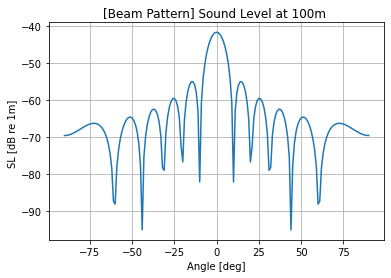

In [133]:
# Plotting - note I only calculate from -90 to 0.  Here I plot symmetrically though
angle=np.concatenate((theta, -1*np.flip(theta[:-1])))*180/np.pi
pressure=np.concatenate((P, np.flip(P[:-1])))
                       
plt.plot(angle, pressure); plt.grid()
plt.xlabel("Angle [deg]"), plt.ylabel("SL [dB re 1m] ")
plt.title("[Beam Pattern] Sound Level at 100m ")
plt.show()

In [143]:
## Copy Paste to do problem on Earth - note will polute global variables
## Copy of the problem contants
c=1540        # m/s, sea water, cold
f=8e3         # 1/s
lmbd = c/f    # m
rho = 1025   # kg/m^3, sea water
un = 0.001    # m/s
k = 2*np.pi / lmbd
print("[Earth] Wavelength: {:.3f} [m]; Wavenumber: {:.3f} [1/m]".format(lmbd, k))

## Code to calculate beam pattern
#
#  Calculate at constant R vs theta, 
#  Constants should be fairly obvious, aperature dimention is L, discretized into N pieces
#  Theta is taken to be 0 in the +z direction, positive values rotate towards +y direction
#
L = 0.5    
N=101
# do calculation from -90 to 90 degrees 
theta=np.linspace(-90,0,181)*(np.pi/180)
P=np.zeros(181)

Rmag = 100.0      # nominal distance to center of transducer, [m]
y=Rmag * np.sin(theta); z = Rmag * np.cos(theta); x = 0 
xs = np.linspace(-L,L,N)
ys= np.linspace(-L,L,N)
dx = 2*L/(N-1); dy = 2*L/(N-1);
dp = np.zeros(N*N, dtype=np.csingle);
print("Moedling with dx ~ {:.2f} wavelength".format(dx/lmbd))

for i in range(theta.shape[0]):
    idx = 0
    for _xs in xs:
        for _ys in ys:
            R = np.sqrt((x-_xs)**2 + (y[i]-_ys)**2 + z[i]**2)
            #print("For values xs: {:.3f}, ys: {:.3f}, theta: {:.3f}, y: {:.3f}, z: {:.3f}, R: {:.3f}".format(xs,ys,theta,y,z,R))

            # note the 2 pi drops 
            dp[idx] = -1j * f * rho * un * dx * dy /R * (np.cos(k*R) + 1j * np.sin(k*R))
            idx+=1

    # Check pressure..  save as dB re 
    p = dp.sum()
    p = np.sqrt(p*np.conjugate(p)).real
    P[i] = 20*np.log10(p/1e-6)


# Normalize far field source re 1 m [40dB Spreading loss for 100m], note last calculation is theta = 0
TL = 20*np.log10(Rmag)
print("TL relative to 1m: {:.3f} [dB]".format(TL))
P1 = P[-1]+TL
print("[Earth] Source Level at 0 deg: {:.3f} [dB re 1uPa] at R= {:.4} [m]".format(P[-1], Rmag))
# Normalizing far field source (at 100m) to dB re SL at 1m
P-=P1
print("[Earth] Equivalent Source Level at 0 deg: {:.3f} [dB re 1uPa] at 1 [m]".format(P1))


[Earth] Wavelength: 0.193 [m]; Wavenumber: 32.640 [1/m]
Moedling with dx ~ 0.05 wavelength
TL relative to 1m: 40.000 [dB]
[Earth] Source Level at 0 deg: 158.448 [dB re 1uPa] at R= 100.0 [m]
[Earth] Equivalent Source Level at 0 deg: 198.448 [dB re 1uPa] at 1 [m]


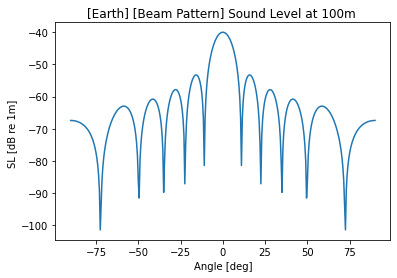

In [144]:
# Plotting - note I only calculate from -90 to 0.  Here I plot symmetrically though
angle=np.concatenate((theta, -1*np.flip(theta[:-1])))*180/np.pi
pressure=np.concatenate((P, np.flip(P[:-1])))
                       
plt.plot(angle, pressure)
plt.grid()
plt.xlabel("Angle [deg]"), plt.ylabel("SL [dB re 1m] ")
plt.title("[Earth] [Beam Pattern] Sound Level at 100m ")
plt.show()

### Problem 2

In this problem we are to try out a relatively simple approach to modeling ducted propagation in the atmosphere.

**Notes on Solution**

- Only need to expand out to about N = 10 terms to see solution converge
- I plot the equivalent TL plot from the notes from 2_1 to validate my simulation
- I plot SPL for c = 300 m/s to 250km.  
- I plot SPL for c = 310 m/s to 250km.  I expected the pattern to just stretch a little but it's clearly not quite that straightforward.

- For the particle velocity, I did by hand the derivatives for the 4 $R$ terms, and use the conservation law 
- $\rho_0 \frac{\partial \vec{v}}{\partial t} = - \vec{\nabla} P$ for the $\hat{y}$ component expect to have something like $-i \omega \rho_0 v_y = A\frac{\partial R}{\partial y}(\frac{-1}{R} + ik)\frac{e^{jkR}}{R}$ for each term in the pressure expansion.
- I don't have a clear intuition or motivation for why you might measure $v_y$ but the values are at least reasonable wrt to values from HW 1 & 2.
- Also, I was able to vectorize calculation of P, but because of the dervative term $v_y$ wasn't immediately obvious

Conditions

- $c \approx 300 m/s$ and $310 m/s$
- $f = 0.1Hz$ which implies $\lambda = 3km$ so the interference pattern should come out at resolutions $\approx \lt 1km$
- $D = 44km$ this is the height of the ducted channel
- $h_s = 15km$ this is the z coordinate of the source
- Plot vs $x \in (1km, 250km)$
- Ideally also make images in $(x,z)$ showing the interference patterns

In [2]:
# Solution strategy: Generate functions to create 4 distances Rn(x,z,zs,n,D)
# 
# Note vectorize this
# better way to do this would be to return matrix in form: n rows, N columns
# DONE
#
# x is a Nx dimension vector; n is highest order term to keep in expansion
# returns a (n rows, Nx cols) matrix
#
#
def R1n(x,z,za,n,D,y=0.0):
    r1n = np.zeros((n+1, x.shape[0]))
    for i in range(1+n):  # should iterate from 0 to n
        r1n[i,:] = np.sqrt(x**2 + y**2 + (z - zs - 2*i*D)**2 )
    return r1n

def R2n(x,z,za,n,D,y=0.0):
    r2n = np.zeros((n+1, x.shape[0]))
    for i in range(n+1):
        r2n[i,:] = np.sqrt(x**2 + y**2 + (z + zs - 2*(i+1)*D)**2 )
    return r2n

def R3n(x,z,za,n,D,y=0.0):
    r3n = np.zeros((n+1, x.shape[0]))
    for i in range(n+1):
        r3n[i,:] = np.sqrt(x**2 + y**2 + (z + zs + 2*i*D)**2 )
    return r3n

def R4n(x,z,za,n,D,y=0.0):
    r4n = np.zeros((n+1, x.shape[0]))
    for i in range(n+1):
        r4n[i,:] = np.sqrt(x**2 + y**2 + (z - zs + 2*(i+1)*D)**2 )
    return r4n



In [20]:
# Generate pressure data vs x
# choose N, choose discretization..
zs = 14; z = 14;   # km - should be between 0 and D, 
A = 20 # [Pa m]
D = 44 # km - Height of the channel

x = np.linspace(1,250,2501)                 # Distance [km]
#x = np.linspace(0.1,30*lmbda,2501) 
p = np.zeros(2501, dtype = np.csingle)
ref = 20*np.log10(A/1000/np.sqrt(x)/20e-6)  # Cylindrical reference, x in km
sref = 20*np.log10(A/1000/x/20e-6)          # Spherical reference, x in km

Nmax=50
c_air = 310; freq = 0.1; lmbda = c_air/freq/1000;  k_air = 2*np.pi/lmbda # needs to be in km
print("k_air = {:.6f} [1/km], lambda = {:.1f} [km]".format(k_air,lmbda))

# For Reference plot (to comare with class notes)
# D = 3*lmbda
# z = zs = D/2

# each of these are n rows x Nx columns
r1n=R1n(x,z,zs,Nmax,D)
r2n=R2n(x,z,zs,Nmax,D)
r3n=R3n(x,z,zs,Nmax,D)
r4n=R4n(x,z,zs,Nmax,D)

p = A/1000*((np.exp(1j*k_air*r1n))/r1n - 
       (np.exp(1j*k_air*r2n))/r2n -
       (np.exp(1j*k_air*r3n))/r3n +
       (np.exp(1j*k_air*r4n))/r4n )

print("Shape of P: {}".format(p.shape))
# sum the columns
P = p.sum(axis=0)
pref = 20e-6
dB = 20 * np.log10( np.sqrt(np.real(P*np.conjugate(P)))/pref)
                   

k_air = 2.026834 [1/km], lambda = 3.1 [km]
Shape of P: (51, 2501)


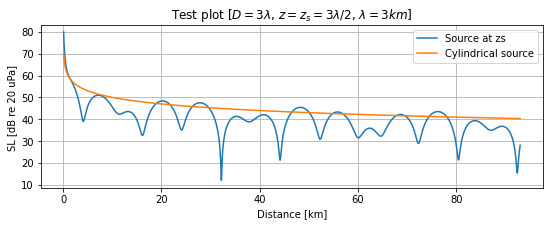

In [17]:
# Plot 0 
# Reference / test plot - to lecture 2_1_2023, with D = 3 lambda, z=zs=3*lambda/2
plt.figure(figsize=(9, 3))
plt.plot(x,dB, label='Source at zs')
plt.plot(x,ref, label='Cylindrical source')

plt.xlabel("Distance [km]"), plt.ylabel("SL [dB re 20 uPa] ")
plt.title("Test plot [$D = 3\lambda$, $z = z_s = 3 \lambda/2$, $\lambda = 3km$]")
plt.grid(); plt.legend();
plt.show()

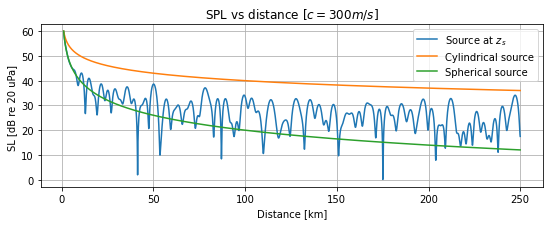

In [19]:
# Plot 1 - 250 km, D = 44km; z=zs=14km
# For reference, 10 lambda is 30 km
plt.figure(figsize=(9, 3))
plt.plot(x,dB, label='Source at $z_s$')
plt.plot(x,ref, label='Cylindrical source')
plt.plot(x,sref, label='Spherical source')
plt.xlabel("Distance [km]"), plt.ylabel("SL [dB re 20 uPa] ")
plt.title("SPL vs distance [$c=300 m/s$]")
plt.grid(); plt.legend();
plt.show()
plt.show()

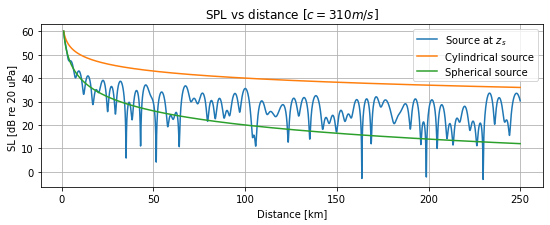

In [21]:
# Plot 2 - 250 km, D = 44km; z=zs=14km
# c -> 310 m/s, lambda increases by 3%, pattern should be stretched along x
# 
plt.figure(figsize=(9, 3))
plt.plot(x,dB, label='Source at $z_s$')
plt.plot(x,ref, label='Cylindrical source')
plt.plot(x,sref, label='Spherical source')
plt.xlabel("Distance [km]"), plt.ylabel("SL [dB re 20 uPa] ")
plt.title("SPL vs distance [$c=310 m/s$]")
plt.grid(); plt.legend();
plt.show()
plt.show()

### Particle Velocity

I ultimately find that the 4 terms will simplify a little bit.  The vertical direction is $\hat{z}$ and so the derivative of $P$ wrt z is done through the distance, $R(n,z,z_s,y)$

$\frac{\partial }{\partial z}\frac{e^(ikR)}{R} = (ik - \frac{1}{R})\frac{e^{ikR}}{R} \frac{\partial R}{\partial z}$ and I find that the $\frac{\partial R}{\partial z}$ term simplifies a bit.

I had to rework the solution strategy a little, 

Notes on Units:

The $u_z$ term brings in a factor of $\frac{1}{\rho \omega}$ from cons of momentum equation

The $\frac{\partial }{\partial z} P$ term has units $[ km^{-2}]$, need to scale that to meters to get correct overall units for $u_z$ of $m/s$

In [23]:
# Solution strategy for velocity, 
# unfortunately couldn't easily vectorize in n dimension
# 
#
def _R1n(x,z,za,n,D,y=0.0):
    return np.sqrt(x**2 + y**2 + (z - zs - 2*n*D)**2 )

def _R2n(x,z,za,n,D,y=0.0):
    return np.sqrt(x**2 + y**2 + (z + zs - 2*(n+1)*D)**2 )

def _R3n(x,z,za,n,D,y=0.0):
    return np.sqrt(x**2 + y**2 + (z + zs + 2*n*D)**2 )

def _R4n(x,z,za,n,D,y=0.0):
    return np.sqrt(x**2 + y**2 + (z - zs + 2*(n+1)*D)**2 )

In [36]:
# Vertical particle velocity
# 
zs = 14; z = 14;   # km - should be between 0 and D, 
A = 20 # [Pa m]
D = 44 # km - Height of the channel
f = 0.1

x1 = np.linspace(0.1,250,1001)
Nmax=100
u=np.zeros((Nmax, x1.shape[0]), dtype=np.csingle)

# set up constants [note lambda in km, k in km^-1]
c_air = 300; freq = 0.1; lmbda = c_air/freq/1000;  k_air = 2*np.pi/lmbda # needs to be in km
p0 = 1000  # g/m^3. (so 1 kg/m^3), compared to 1.225 at sea level?  Need to validate

print("k_air = {:.6f} [1/km], lambda = {:.1f} [km]".format(k_air,lmbda))

#Since the n comes out with the differentiation, my nicer vectorized solution doesn't work easily
for n in range(Nmax):
    r1n=_R1n(x1,z,zs,n,D)
    r2n=_R2n(x1,z,zs,n,D)
    r3n=_R3n(x1,z,zs,n,D)
    r4n=_R4n(x1,z,zs,n,D)
    u[n,:] = A/p0/np.pi/2/freq*(
    (1j*k_air*r1n - 1)*(np.exp(1j*k_air*r1n))/1e6/(r1n**3)*(z-zs-2*n*D) - 
    (1j*k_air*r2n - 1)*(np.exp(1j*k_air*r2n))/1e6/(r2n**3)*(z+zs-2*(n+1)*D) - 
    (1j*k_air*r3n - 1)*(np.exp(1j*k_air*r3n))/1e6/(r3n**3)*(z+zs+2*n*D) + 
    (1j*k_air*r4n - 1)*(np.exp(1j*k_air*r4n))/1e6/(r4n**3)*(z-zs+2*(n+1)*D)) 

# sum the columns
U = u.sum(axis=0)
print(U.shape)   
# implicitly re 1 m/s
# -170 dB => u ~ nm / s   (too small??)
dBu = 10*np.log10(np.real(U*np.conjugate(U)))

k_air = 2.094395 [1/km], lambda = 3.0 [km]
(1001,)


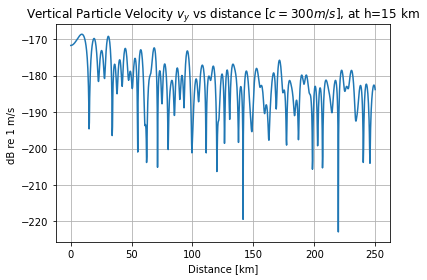

In [37]:
plt.plot(x1, dBu)
plt.xlabel("Distance [km]"), plt.ylabel("dB re 1 m/s ")
plt.title("Vertical Particle Velocity $v_y$ vs distance [$c=300 m/s$], at h=15 km")
plt.grid(); plt.show()